In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
# SQL
import sqlite3

In [205]:
def sql_preprocess(cursor, table, columns):
    # Select the columns
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_col AS
        SELECT {", ".join(columns)} FROM {table}
    ''')

    # Identify numeric columns
    cursor.execute(f'PRAGMA table_info(filtered_col)')
    columns_info = cursor.fetchall()
    numeric_cols = [col[1] for col in columns_info if col[2] in ('INTEGER', 'REAL')]

    # Null condition
    null_condition = ' AND '.join(f'{col} IS NULL' for col in numeric_cols)
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_null AS
        SELECT * FROM filtered_col
        WHERE NOT ({null_condition})
    ''')

    # Group by day
    cursor.execute(f'''
        CREATE TEMP TABLE filtered_day AS
        SELECT 
            COUNT(*) AS row_count,
            DATE(utc_timestamp) AS utc_day,
            {', '.join([f'AVG({col}) AS {col[3:]}_avg' for col in numeric_cols])}
        FROM filtered_null
        GROUP BY utc_day
    ''') # DATE(SUBSTR(cet_cest_timestamp, 1, 19)) AS cet_day

    return 'filtered_day'

def sql_reader(db_path, table):
    conn = sqlite3.connect(db_path) # Connect to the SQLite database
    cursor = conn.cursor() # Declare a cursor

    # Get the columns matching the pattern
    cursor.execute(f"""
        SELECT name
        FROM pragma_table_info('{table}')
        WHERE name LIKE '%timestamp%' OR name LIKE 'BE%'               
    """)
    columns = [row[0] for row in cursor.fetchall()]

    # Preprocess
    filtered_table = sql_preprocess(cursor, table, columns)
    df = pd.read_sql_query(f"SELECT * FROM {filtered_table}", conn, parse_dates=['utc_day'])

    conn.commit()
    conn.close()

    return df

In [206]:
df_cons = sql_reader('../DB/time_series.sqlite', 'time_series_60min_singleindex')
df_weather = sql_reader('../DB/weather_data.sqlite', 'weather_data')

In [228]:
db_path = '../DB/energy_weather.sqlite' # Create the database
conn = sqlite3.connect(db_path) # Connect to the SQLite database
# Create tables from dataframes
df_cons.to_sql('consumption', conn, if_exists='replace', index=False)
df_weather.to_sql('weather', conn, if_exists='replace', index=False)
# Create joined table based on utc_day
cons_select = [f'c.{col}' for col in df_cons.columns if col != 'utc_day']
weather_select = [f'w.{col}' for col in df_weather.columns if col not in df_cons.columns]
select_clause = ", ".join(cons_select + weather_select)
conn.execute("DROP TABLE IF EXISTS joined_data")
join_query = f"""
    CREATE TABLE joined_data AS
    SELECT 
        c.utc_day,
        {select_clause}
    FROM consumption c
    INNER JOIN weather w ON c.utc_day = w.utc_day
""" # STRFTIME('%Y', c.utc_day) AS year, STRFTIME('%m', c.utc_day) AS month, STRFTIME('%w', c.utc_day) AS day_of_week,
conn.execute(join_query)
df_joined = pd.read_sql_query(f"SELECT * FROM joined_data", conn, parse_dates=['utc_day'])
conn.commit()
conn.close()
df_joined.head(5)

,utc_day,row_count,load_actual_entsoe_transparency_avg,load_forecast_entsoe_transparency_avg,solar_generation_actual_avg,wind_generation_actual_avg,wind_offshore_generation_actual_avg,wind_onshore_generation_actual_avg,temperature_avg,radiation_direct_horizontal_avg,radiation_diffuse_horizontal_avg
0,2015-01-01,24,9085.916667,9768.833333,239.304375,1176.220435,604.945217,571.275217,0.478875,16.781469,24.558072
1,2015-01-02,24,9977.791667,9964.000000,88.245000,1230.979167,614.502500,616.476667,3.592583,6.822604,24.647204
2,2015-01-03,24,10167.041667,10112.666667,11.927500,528.915833,285.200833,243.715000,1.103125,0.307500,12.280505
3,2015-01-04,24,9925.166667,9559.083333,152.966250,220.054583,92.094583,127.960000,0.753250,27.074776,21.287341
4,2015-01-05,24,11618.875000,10904.708333,131.757083,327.642083,142.565417,185.076667,-0.065750,2.537711,24.178427


In [224]:
# Display curves against utc_day using plotly and render in browser
import plotly.express as px
fig = px.line(df_joined, x='utc_day', y=df_joined.columns[2:])
fig.show(renderer="browser")

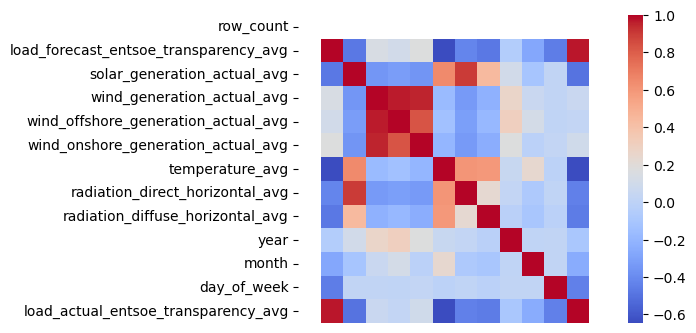

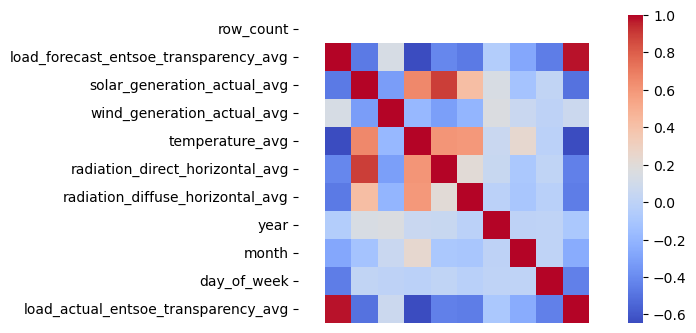

In [ ]:
'''
Apply the required steps to produce a regression model (no matter which model) in order to determine the load_actual as a function of other variables:
1) Create the training and test set
2) Plot a correlation heatmap for the raw training set
3) Remove outliers in the training set using the method of your choice and apply the outlier filtering to the test set
4) Apply a correlation filter in the training set to remove highly correlated columns and apply the filtering to the test set
5) Plot a correlation heatmap for the cleaned training set
NB : Normalise when need
6) Add a todo for the model trained on the training set and tested with the test set (using several scores) to produce the final model
'''
df = df_joined.copy()
df['year'] = df['utc_day'].dt.year
df['month'] = df['utc_day'].dt.month
df['day_of_week'] = df['utc_day'].dt.dayofweek

target = 'load_actual_entsoe_transparency_avg'
features = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target]

X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def plot_corr_heatmap(df_plot):
    plt.figure(figsize=(5,4))
    corr = df_plot.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=True, cbar=True, cbar_kws={'orientation': 'vertical', 'pad': 0.1})
    plt.show()

plot_corr_heatmap(pd.concat([X_train, y_train], axis=1))

def outlier_filter(df_in, iqr_multiplier=1.5): # Using IQR per-feature
    # TODO


